In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

def make_plots(QDP,retention):
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        if QDP.experiments[0]['variable_list']==[]:
            data=range(0,np.size(retention['ivar'],axis=1))
            xlab = 'iteration'
        else:
            xlab = QDP.experiments[0]['variable_desc'][QDP.experiments[0]['variable_list'][0]]['description']
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    plt.show()
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

    ### Beam positions plot, differential

    Xdata=np.squeeze(QDP.get_beampositions()['RedX']+QDP.get_beampositions()['FORTX'])
    Ydata=np.squeeze(QDP.get_beampositions()['RedY']-QDP.get_beampositions()['FORTY'])
    fig, ax = plt.subplots()
    #ax.scatter(Xdata-Xdata[0],Ydata-Ydata[0])
    ax.plot(data,Xdata-Xdata[0],'o',label='Delta X')
    ax.plot(data,Ydata-Ydata[0],'o',label='Delta Y')
    plt.show()
    #ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Drift @ atom plane(um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    
    ### Beam positions plot, Absolute
    
    Xdata_Red=-np.squeeze(QDP.get_beampositions()['RedX'])
    Xdata_FORT=np.squeeze(QDP.get_beampositions()['FORTX'])
    Ydata_Red=np.squeeze(QDP.get_beampositions()['RedY'])
    Ydata_FORT=np.squeeze(QDP.get_beampositions()['FORTY'])
    fig, ax = plt.subplots()
    ax.plot(data,Xdata_Red-np.round(np.nanmedian(Xdata_Red)),'o',label='Red X, offset:{}'.format(np.round(np.nanmedian(Xdata_Red))))
    ax.plot(data,Xdata_FORT-np.round(np.nanmedian(Xdata_FORT)),'o',label='FORT X, offset:{}'.format(np.round(np.nanmedian(Xdata_FORT))))
    ax.plot(data,Ydata_Red-np.round(np.nanmedian(Ydata_Red)),'o',label='Red Y, offset:{}'.format(np.round(np.nanmedian(Ydata_Red))))
    ax.plot(data,Ydata_FORT-np.round(np.nanmedian(Ydata_FORT)),'o',label='FORT Y, offset:{}'.format(np.round(np.nanmedian(Ydata_FORT))))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

# middle of r1 and r2


In [3]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
exp_id='2018_02_10_13_57_50_Open loop Ramsey Full Ramsey curve, r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


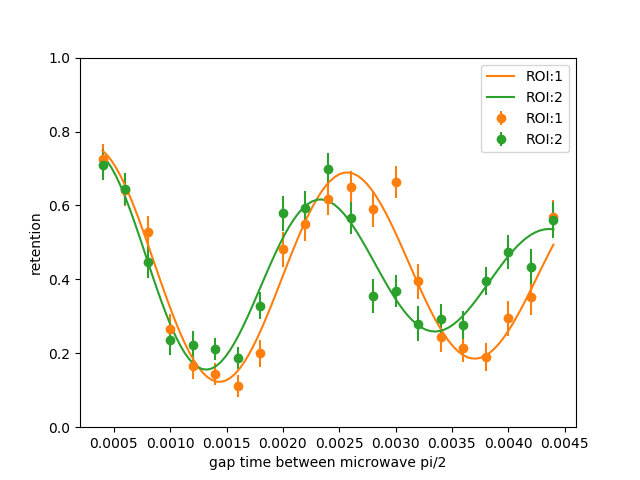

ROI:1, tau : 0.0096314392337, amplitude 0.348445140419 , freq:441.501736223, phase:0.690227877478, offset:0.42254643609
ROI:2, tau : 0.00400551768483, amplitude 0.361550545983 , freq:492.687341485, phase:0.549923404149, offset:0.415056493675


In [4]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.01,0.4,500,0,0.4]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    try:
        fit,pcov = curve_fit(decaying_sin,data,reten,guesses)
    except RuntimeError:
        error=1
    if error is not 1:
        print "ROI:{}, tau : {}, amplitude {} , freq:{}, phase:{}, offset:{}".format(roi,fit[0],fit[1],fit[2],fit[3],fit[4])
        fitted_parameters.append(fit[0])
        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0],fit[1],fit[2],fit[3],fit[4])
        plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

# Open loop, fixed gap time
2018_02_10_14_14_37_Open loop Ramsey fixed gap, r1-r2

In [41]:
exp_id='2018_02_10_14_14_37_Open loop Ramsey fixed gap, r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()


[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


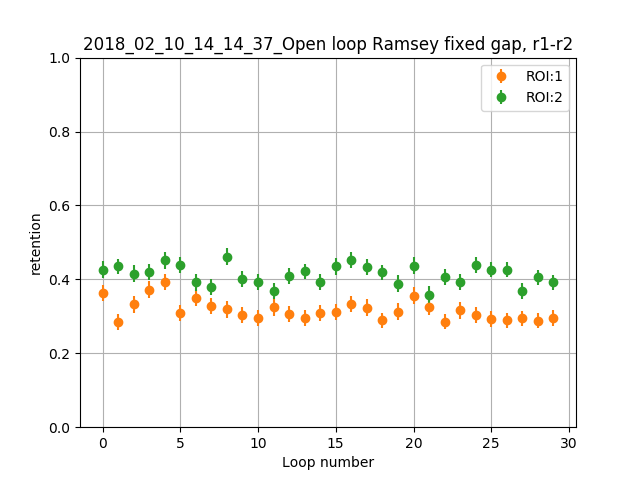

<IPython.core.display.Javascript object>


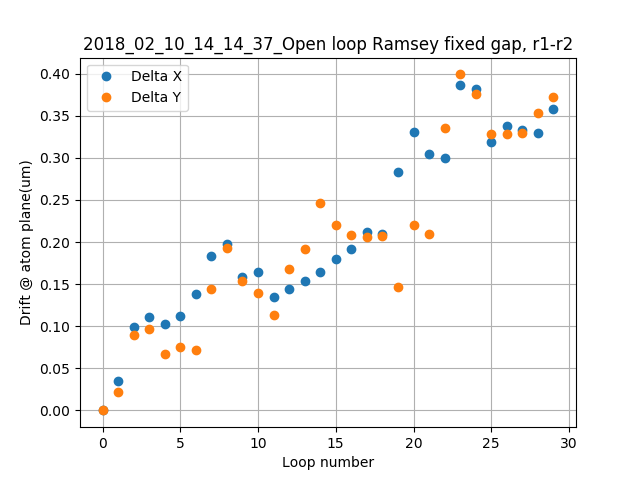

<IPython.core.display.Javascript object>


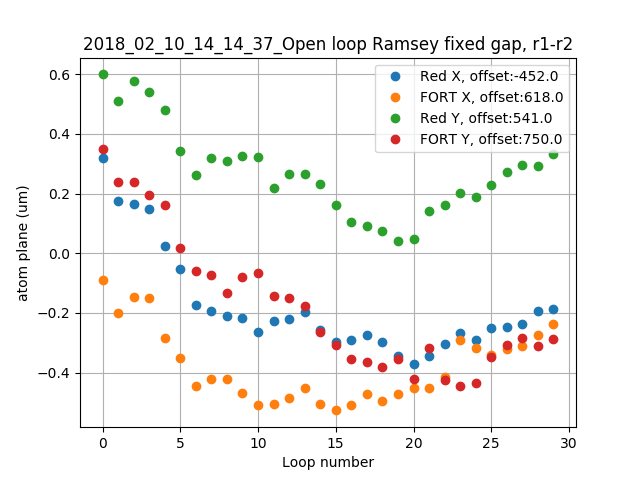

In [42]:
make_plots(q,retention)

<IPython.core.display.Javascript object>


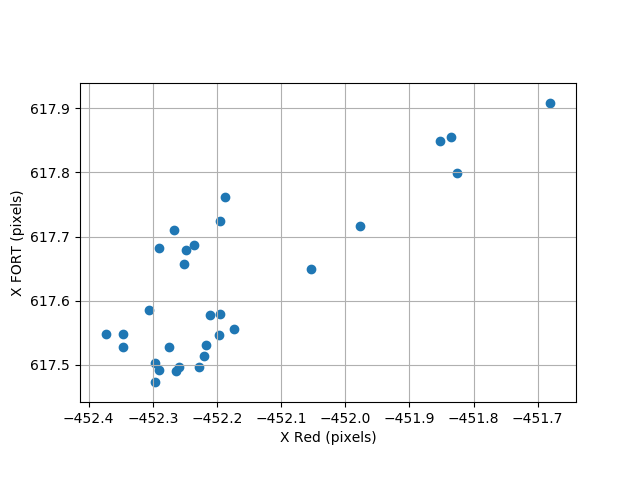

<IPython.core.display.Javascript object>


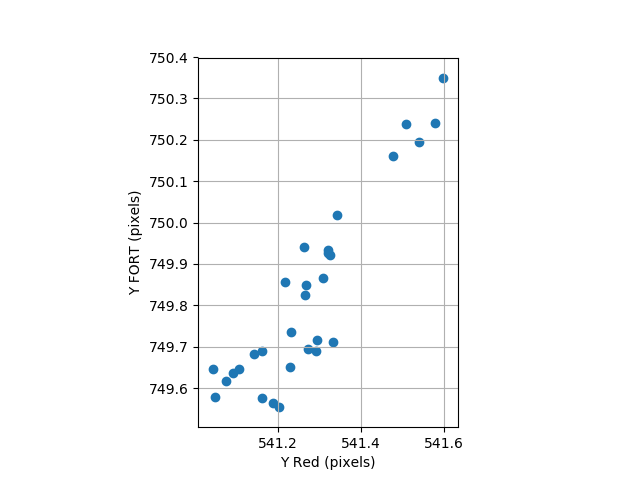

In [50]:
# Doing correlation analysis
Xdata_Red=-np.squeeze(q.get_beampositions()['RedX'])
data=range(0,len(Xdata_Red))
Xdata_FORT=np.squeeze(q.get_beampositions()['FORTX'])
Ydata_Red=np.squeeze(q.get_beampositions()['RedY'])
Ydata_FORT=np.squeeze(q.get_beampositions()['FORTY'])

fig, ax = plt.subplots()
ax.scatter(Xdata_Red,Xdata_FORT)
plt.show()
ax.set_xlabel('X Red (pixels)')
ax.set_ylabel('X FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.scatter(Ydata_Red,Ydata_FORT)
plt.show()
ax.set_xlabel('Y Red (pixels)')
ax.set_ylabel('Y FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

# Open loop, fixed gap time, 
2018_02_09_21_20_15_Open loop Ramsey fixed gap, AOM at r1-r2

In [51]:
exp_id='2018_02_09_21_20_15_Open loop Ramsey fixed gap, AOM at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()
retention = q.apply_thresholds()


[]


<IPython.core.display.Javascript object>


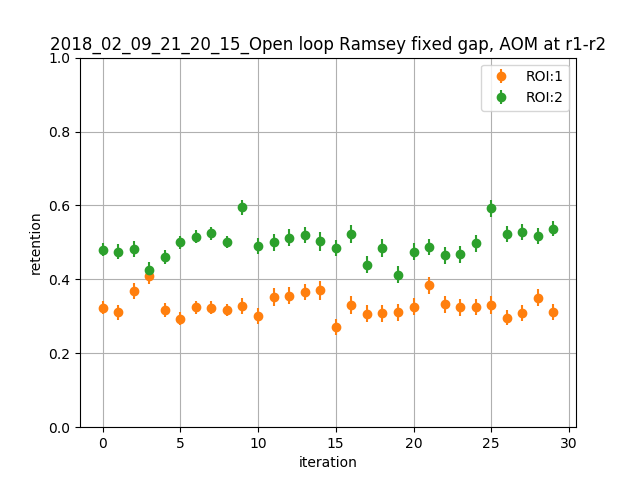

<IPython.core.display.Javascript object>


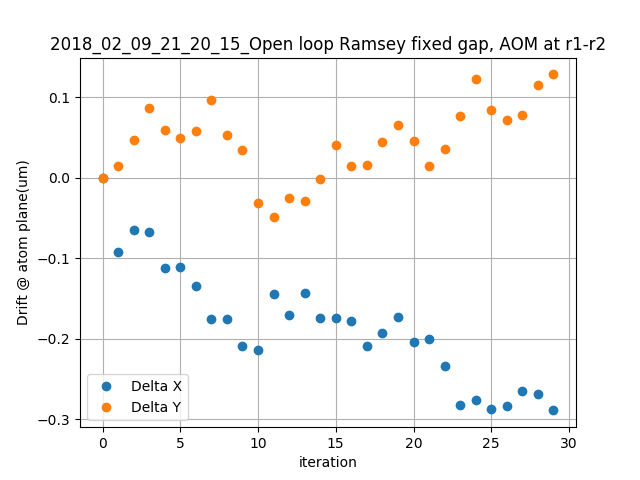

<IPython.core.display.Javascript object>


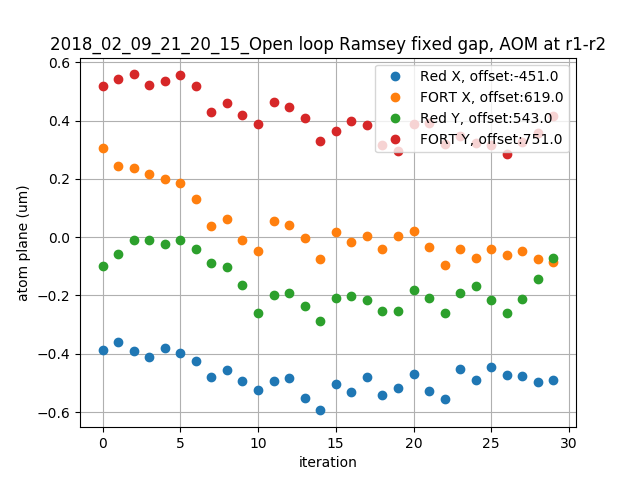

In [52]:
make_plots(q,retention)

<IPython.core.display.Javascript object>


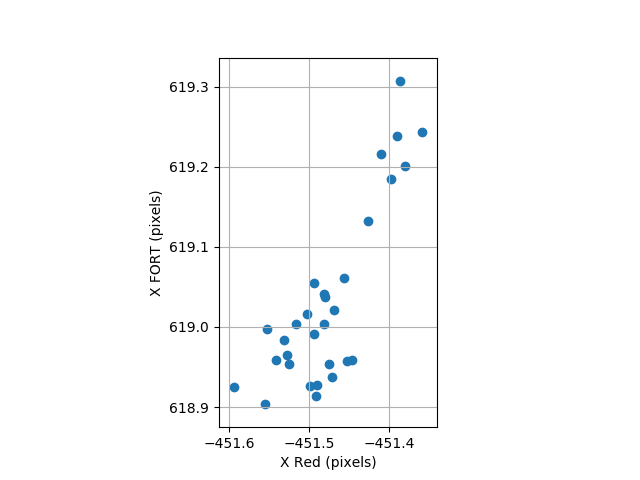

<IPython.core.display.Javascript object>


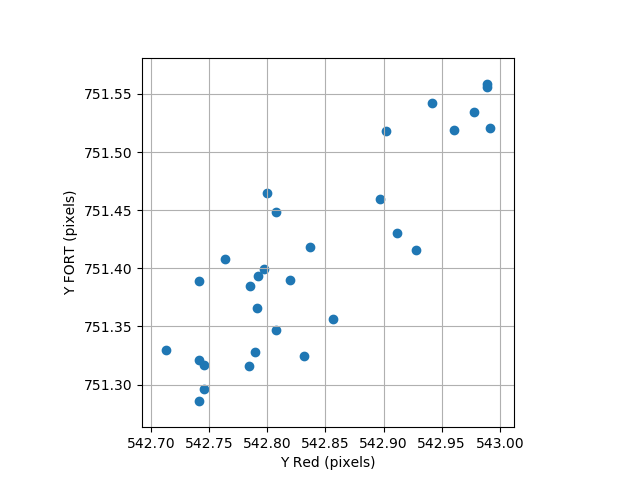

In [55]:
# Doing correlation analysis
Xdata_Red=-np.squeeze(q.get_beampositions()['RedX'])
data=range(0,len(Xdata_Red))
Xdata_FORT=np.squeeze(q.get_beampositions()['FORTX'])
Ydata_Red=np.squeeze(q.get_beampositions()['RedY'])
Ydata_FORT=np.squeeze(q.get_beampositions()['FORTY'])

fig, ax = plt.subplots()
ax.scatter(Xdata_Red,Xdata_FORT)
plt.show()
ax.set_xlabel('X Red (pixels)')
ax.set_ylabel('X FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.scatter(Ydata_Red,Ydata_FORT)
plt.show()
ax.set_xlabel('Y Red (pixels)')
ax.set_ylabel('Y FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

# Closed loop, fixed gap time

In [21]:
exp_id='2018_02_09_23_31_42_Closed loop Ramsey fixed gap, AOM at r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()

[]


{0: [[450], [450], [450]],
 1: [[450], [450], [450]],
 2: [[450], [450], [450]],
 3: [[450], [450], [450]],
 4: [[450], [450], [450]]}

In [22]:
#xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds(dataset='all') 

<IPython.core.display.Javascript object>


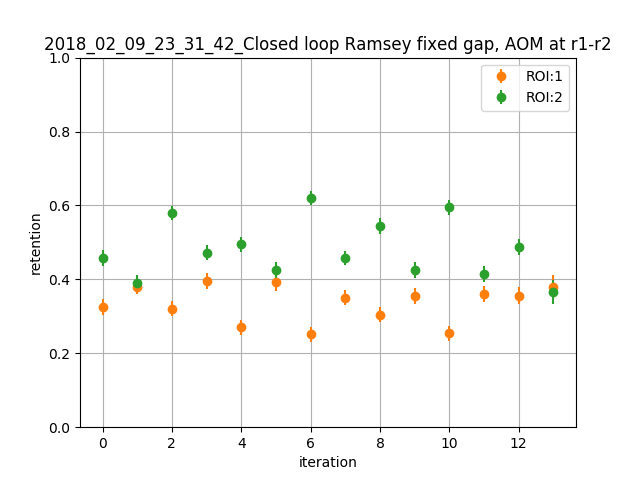

<IPython.core.display.Javascript object>


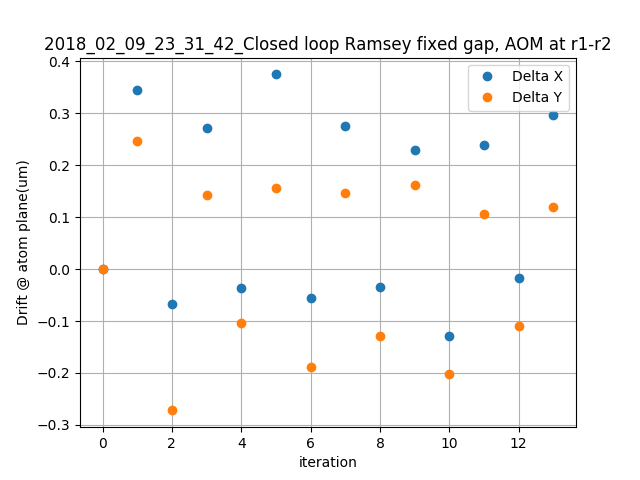

<IPython.core.display.Javascript object>


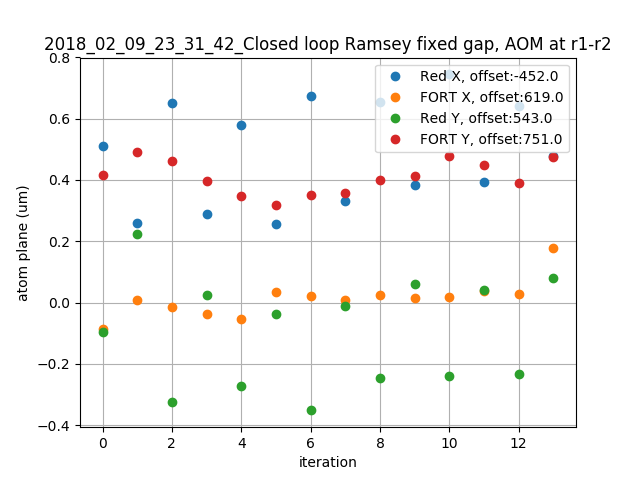

In [23]:
make_plots(q,retention)

<IPython.core.display.Javascript object>


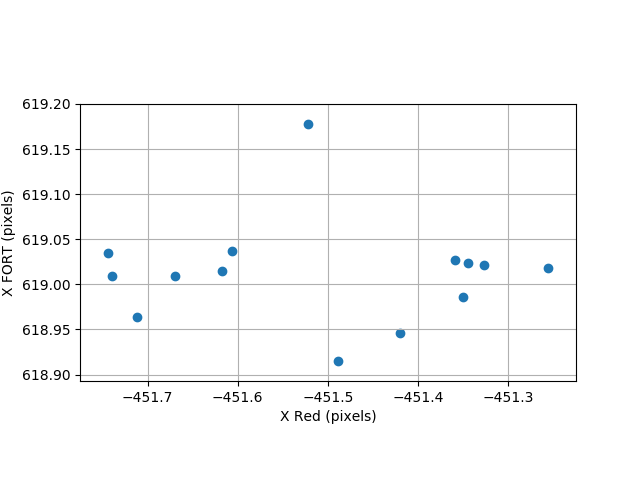

<IPython.core.display.Javascript object>


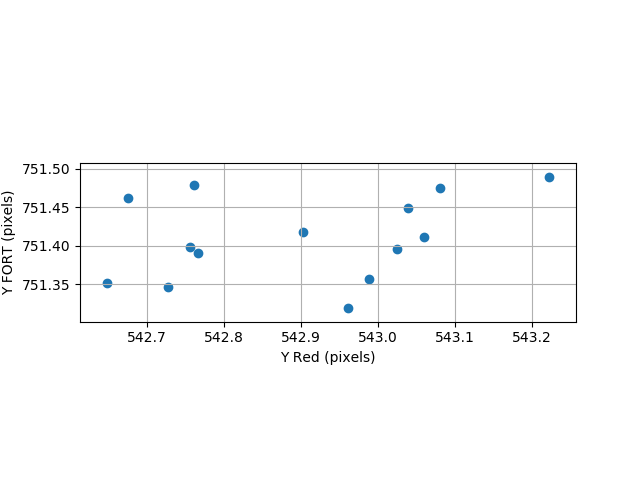

In [25]:
# Doing correlation analysis
Xdata_Red=-np.squeeze(q.get_beampositions()['RedX'])
data=range(0,len(Xdata_Red))
Xdata_FORT=np.squeeze(q.get_beampositions()['FORTX'])
Ydata_Red=np.squeeze(q.get_beampositions()['RedY'])
Ydata_FORT=np.squeeze(q.get_beampositions()['FORTY'])

fig, ax = plt.subplots()
ax.scatter(Xdata_Red,Xdata_FORT)
plt.show()
ax.set_xlabel('X Red (pixels)')
ax.set_ylabel('X FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.scatter(Ydata_Red,Ydata_FORT)
plt.show()
ax.set_xlabel('Y Red (pixels)')
ax.set_ylabel('Y FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

# Closed loop, fixed gap time

In [26]:
exp_id='2018_02_10_15_53_05_closed loop Ramsey fixed gap, r1-r2'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\lib\nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


[u'zz_outermost_iteration']


{0: [[450], [450], [450]],
 1: [[450], [450], [450]],
 2: [[450], [450], [450]],
 3: [[450], [450], [450]],
 4: [[450], [450], [450]]}

In [27]:
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds(dataset=range(0,65)) 

<IPython.core.display.Javascript object>


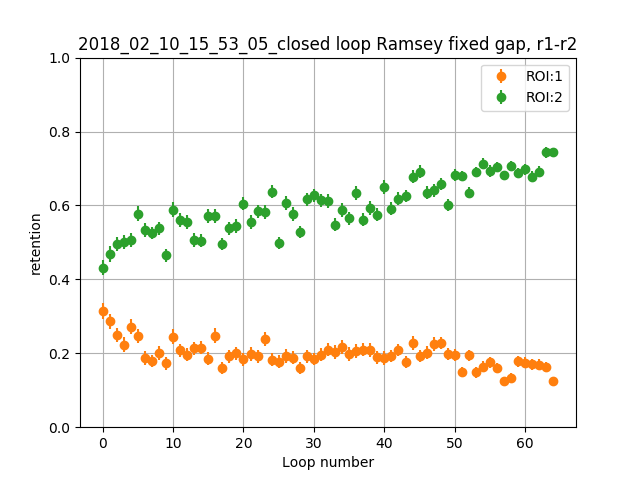

<IPython.core.display.Javascript object>


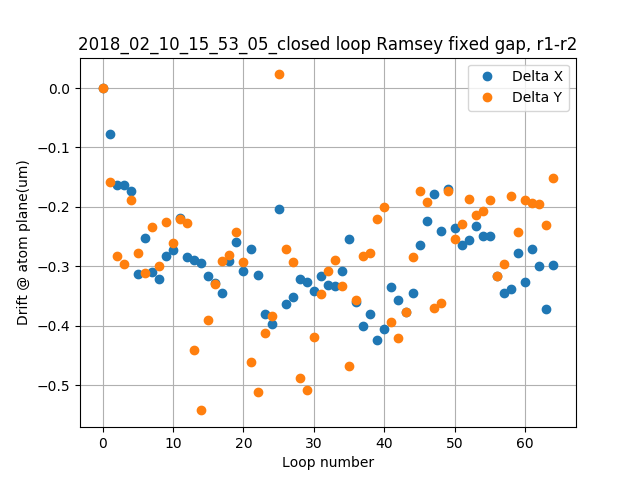

<IPython.core.display.Javascript object>


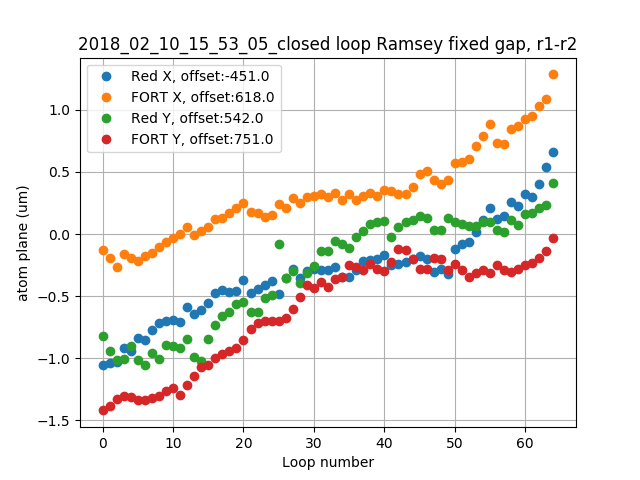

In [28]:
make_plots(q,retention)

<IPython.core.display.Javascript object>


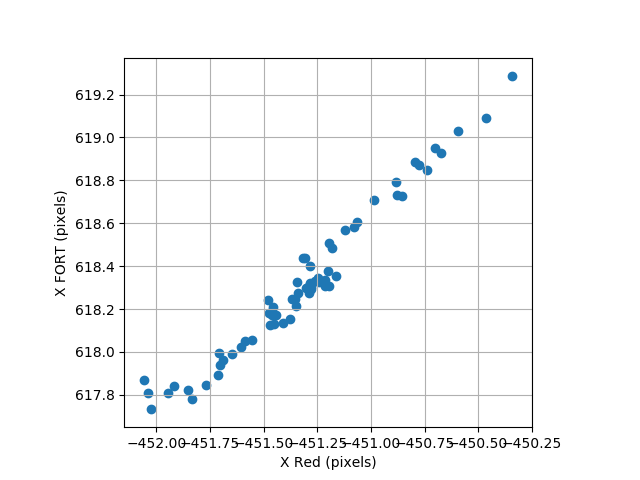

<IPython.core.display.Javascript object>


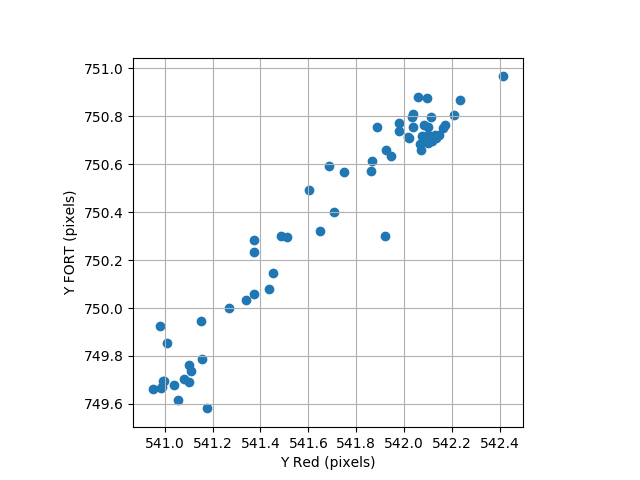

In [29]:
# Doing correlation analysis
Xdata_Red=-np.squeeze(q.get_beampositions()['RedX'])
data=range(0,len(Xdata_Red))
Xdata_FORT=np.squeeze(q.get_beampositions()['FORTX'])
Ydata_Red=np.squeeze(q.get_beampositions()['RedY'])
Ydata_FORT=np.squeeze(q.get_beampositions()['FORTY'])

fig, ax = plt.subplots()
ax.scatter(Xdata_Red,Xdata_FORT)
plt.show()
ax.set_xlabel('X Red (pixels)')
ax.set_ylabel('X FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.scatter(Ydata_Red,Ydata_FORT)
plt.show()
ax.set_xlabel('Y Red (pixels)')
ax.set_ylabel('Y FORT (pixels)')
ax.set_aspect('equal')
ax.grid()
ax.legend()

# Closed loop, fixed gap time

In [35]:
exp_id='2018_02_11_00_41_55_closed loop Ramsey fixed gap, moved x little'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
q.get_thresholds()

[u'zz_outermost_iteration']


{0: [[450], [450], [450]],
 1: [[450], [450], [450]],
 2: [[450], [450], [450]],
 3: [[450], [450], [450]],
 4: [[450], [450], [450]]}

In [36]:
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds(dataset='all') 

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


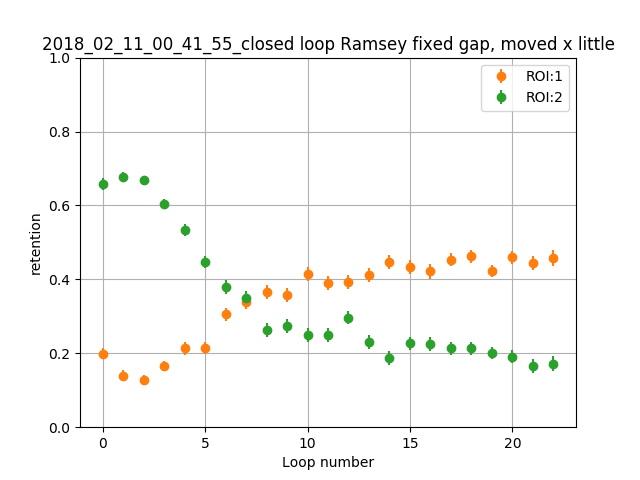

<IPython.core.display.Javascript object>


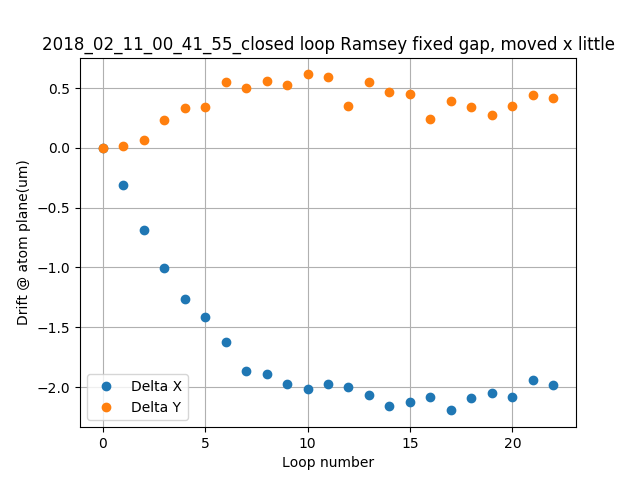

<IPython.core.display.Javascript object>


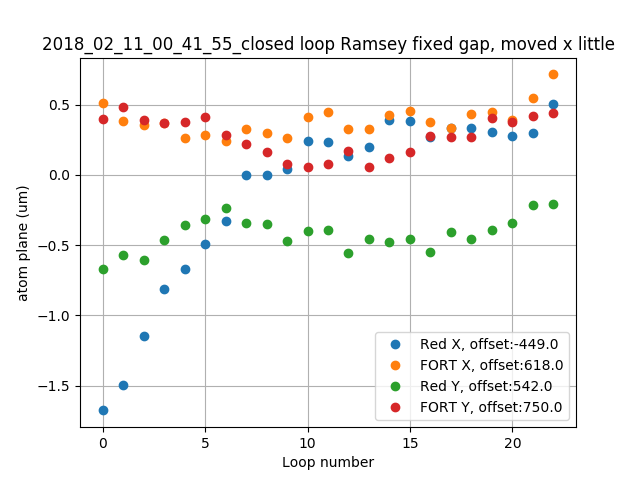

In [37]:
make_plots(q,retention)